# Tobit Regression

### Setup

A normal linear regression models a dependent variable y based on a set of independent variables x, and some error term like this:

$$y = \beta x + u$$

where $\beta$ is some parameter to be estimated. We usually estimate it by minimising the squared error of our model. The model assumes that y depends linearly on x.

Tobit models are a sort of extension of this idea. You use a tobit model when there is some kind of 'corner' solution. This is usually some kind of minimum value that y can take on, although it could also be a maximum value.

Y depends on x linearly for some range of values of x, but otherwise y takes on the corner value. In most examples this corner value is zero, but it could be something else.

Example from genetics. Geneticists study the effects of mutations on fruit flies. They knock out a number of genes from the fly and record how many days the fly lives. The fly can live a number of days, which we treat as continuous. The more genes we knock out the fewer days it lives. Let's say after 10 mutations the majority of flies don't live more than a day. We therefore record the lifespan as zero. With 20 mutations the flies are even less viable, but we cannot record them as living a negative number of days, so we still record them as living for only one day. If we record the number of mutations against days lived we will see a pile up of the data at around zero days. We are sort of losing some information here as much of the data has the same (zero) value.

We could fit a linear model to this data, this would not be wrong, but it might not be optimal. In addition, it may begin to predict some negative values for life span, which does not conform to our knowledge of how our system works.

The tobit model corrects for this (under certain assumptions), in this notebook I work through exactly how this works.


### Make some fake data

An example data. Some students take an exam in the first year of their studies, the exam results are normally distributed around 60%. The second year they take another exam, however, the professor makes this exam incredibly difficult, so that quite some number of students receive zero marks, because they are unable to answer a single question correctly.

For clean mathematics I'm going to centre the first year exam around zero, but nothing is really lost in this assumption.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Make some fake data based on the story I told above.

In [2]:
def get_data(n, beta=0.5, sigma=0.1):
    """
    Returns a data frame of lenth 'n' with first year exam results
    and second year exam results.
    Inputs
    ------
    beta:
        coefficient y = beta*x + noise
    sigma:
        std of the normally distributed noise.
    """

    first_year = np.random.normal(0, 0.3, n)

    # A hypothetical result if it were not capped at 100
    second_year_hidden = beta*first_year + np.random.normal(0, sigma, n)
    second_year = np.array([max(x, 0) for x in second_year_hidden])

    df = pd.DataFrame(
        {'first_year': first_year,
         'second_year': second_year,
         'second_year_hidden': second_year_hidden
        }
    )
    
    return df

In [3]:
# These are the 'true' values of these parameters, latter we will disect the data and try
# to estimate them, as with real data we would not actually know their value.
BETA, SIGMA = 0.5, 0.1

In [4]:
df = get_data(2000, BETA, SIGMA)

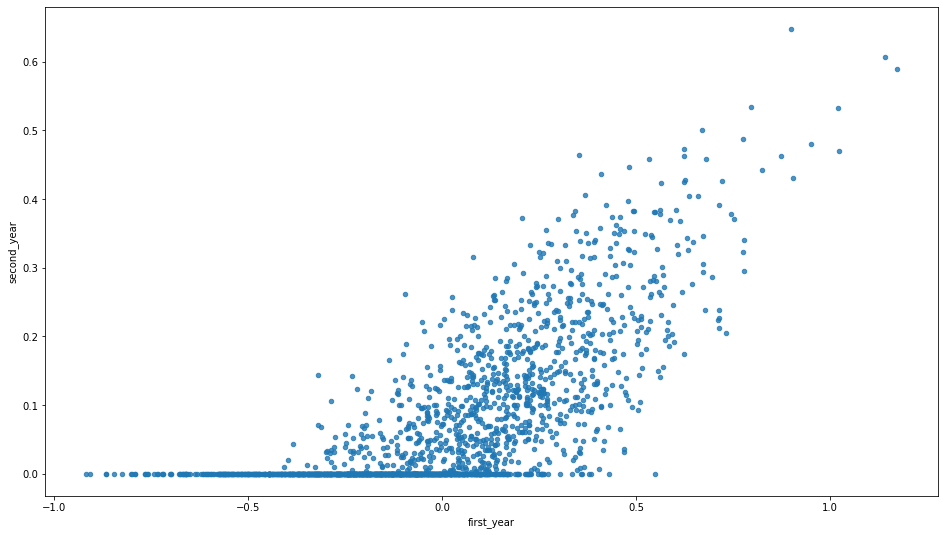

In [5]:
df.plot.scatter(x='first_year', y='second_year', figsize=(16, 9), alpha=0.8)

Now notice what is going on. There is a clear linear trend between x and y. However, the trend is sort of cut off below a certain point, and all the data is concentrated at the 0 mark. If we histogram y we see this clearly.

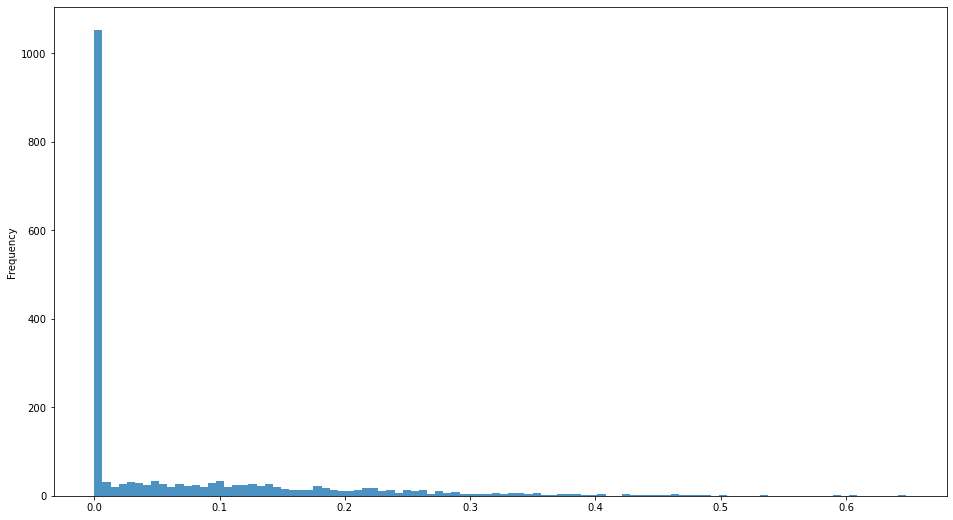

In [6]:
df.second_year.plot.hist(bins=100, figsize=(16, 9), alpha=0.8)

Now it's also instructive to look at the second year hidden variable. This is the hypothetical score that the student would have recieved if the exam was not capped at 0 (say if it had some easier questions to begin with). In reality we don't have access to this data, we only 'pretend' that it exists. Nonetheless, let's look at it.

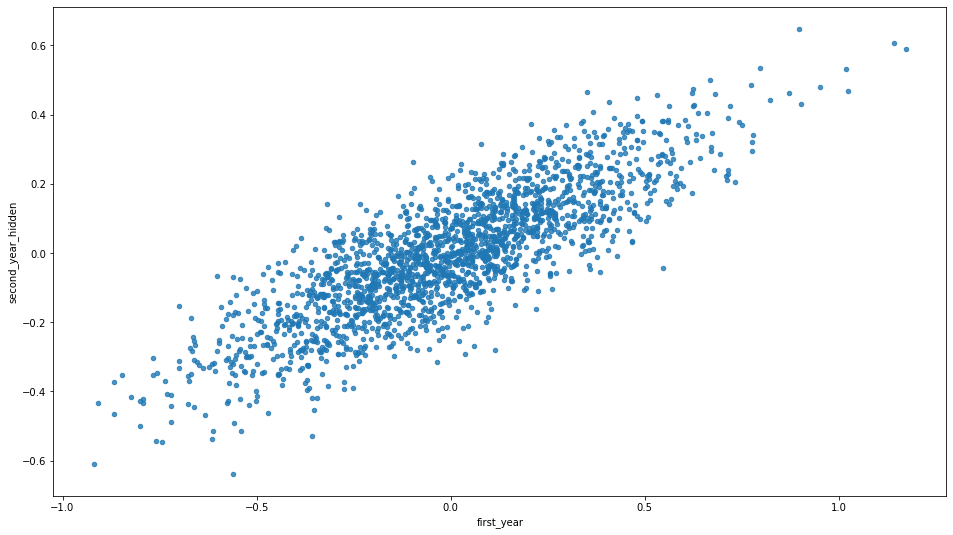

In [7]:
df.plot.scatter(x='first_year', y='second_year_hidden', figsize=(16, 9), alpha=0.8)

It's quite a clear linear relationship, albeit with some noise. We know this because we made up the data.

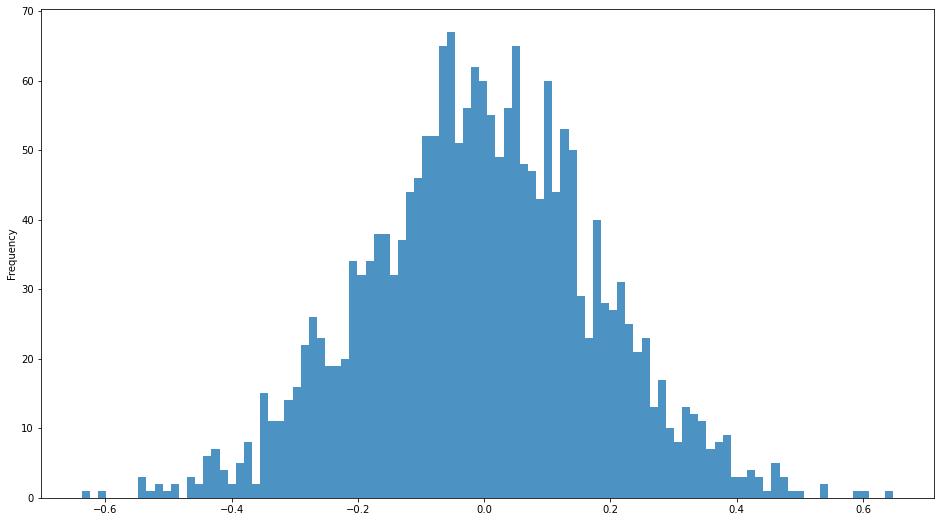

In [8]:
df.second_year_hidden.plot.hist(bins=100, figsize=(16, 9), alpha=0.8)

And the distribution of this data looks roughly normal.

The question now is: what kind of regression would work best between first year and second year results. Let's say that some of the students missed their second year exam and we want the best prediction of what their result would have been if they had taken it.

### Possible regressions

This first obvious approach is simply to run a regression on the entirety of the data. Let's try this.

In [9]:
import statsmodels.formula.api as smf

In [10]:
lr = smf.ols(formula='second_year ~ first_year', data=df)
fit = lr.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            second_year   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     2133.
Date:                Thu, 30 Dec 2021   Prob (F-statistic):          1.93e-317
Time:                        16:17:59   Log-Likelihood:                 2393.5
No. Observations:                2000   AIC:                            -4783.
Df Residuals:                    1998   BIC:                            -4772.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0717      0.002     43.840      0.000       0.069       0.075
first_year     0.2503      0.005     46.181      0.000       0.240       0.261
==============================================================================
Omnibus:                      197.314   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              271.821
Skew:                           0.781   Prob(JB):                     9.44e-60
Kurtosis:                       3.908   Cond. No.                         3.31
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

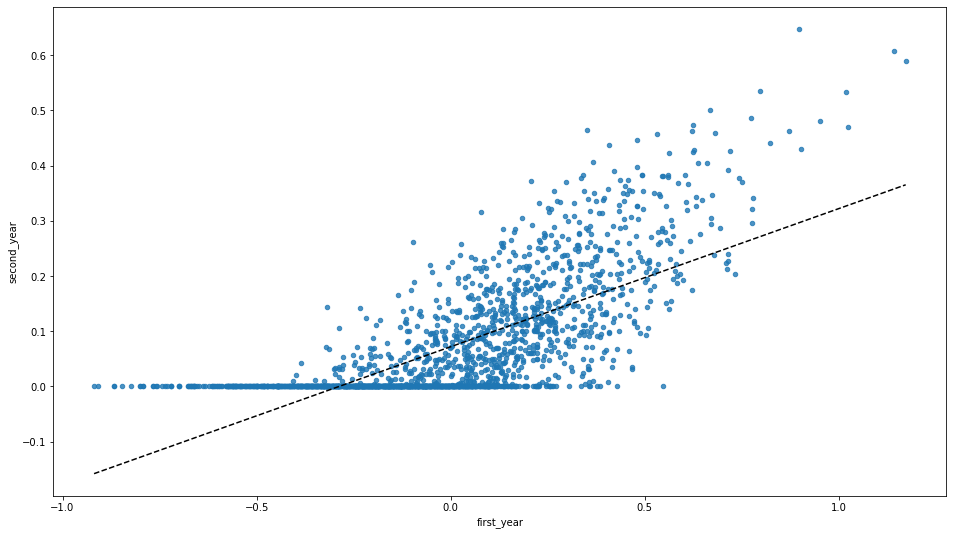

In [11]:
x = df.first_year.min(), df.first_year.max()
def model1(x):
    return fit.params.Intercept + fit.params.first_year*x
y = [model1(xx) for xx in x]
ax = df.plot.scatter(x='first_year', y='second_year', figsize=(16, 9), alpha=0.8)
ax.plot(x, y, '--', color='black')

Notice that the fitted line is not crazy, it does indeed capture some of the variation, but it over shoots at the beginning, it does this to try to compensate for the bunched up points towards the end. However, we know that y is never lower than 0, by assumption, yet this line of best fit actually predicts some negative values. Nonetheless, this might be what you are looking for, and it is indeed the straight line that minimises the squared error given the constraint of a straight line.

Let's also add the predictions of this model to our dataframe, so that we can compare various models as we go along.

In [12]:
df['ols_predictions'] = fit.predict()

In [13]:
ols_mse = ((df.ols_predictions - df.second_year) ** 2).mean()
ols_mse

0.005346265363904039

As an asside, what happens if we cut this line of best fit at 0, does that do a better job. You would imagine it would.

In [14]:
def model1b(x):
    return max(0, model1(x))

df['ols_capped_predictions'] = df.first_year.apply(model1b)

In [15]:
((df.ols_capped_predictions - df.second_year) ** 2).mean()

0.004858500460462228

This model does a little bit better.

### Approach 2

What if we do a regression on only the data that is greater than 0, then if this line is more less than 0 we cap it at that.

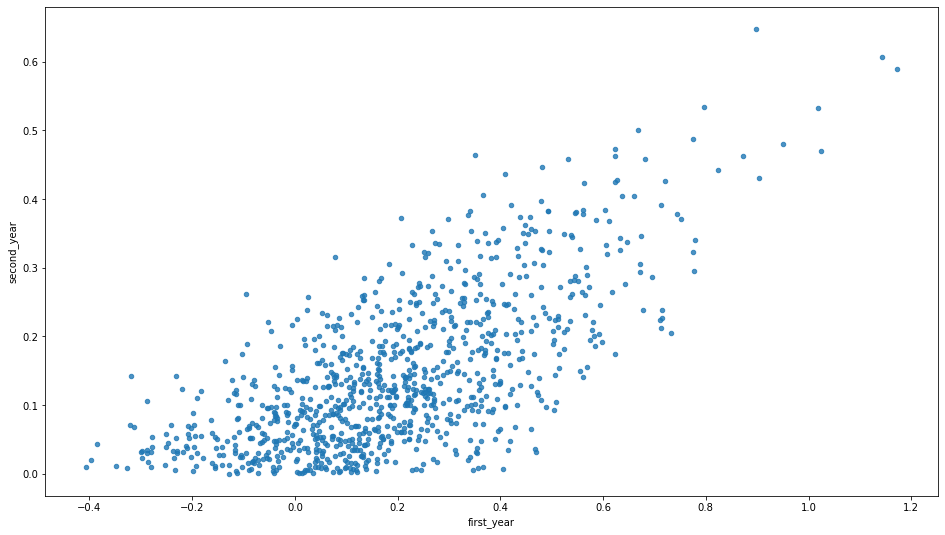

In [16]:
df_cut = df.query('second_year > 0')
df_cut.plot.scatter('first_year', 'second_year', figsize=(16, 9), alpha=0.8)

Let's make a line of fit to this data now.

In [17]:
lr = smf.ols(formula='second_year ~ first_year', data=df_cut)
fit = lr.fit()

And make the line of best fit. We could be clever and work out where this line cuts 0 and then compose the prediction out of two lines, but let's just predict for a large line of xs. Remember, we take this line so long as it is greater than 0, otherwise we chuck out the prediction of 0.

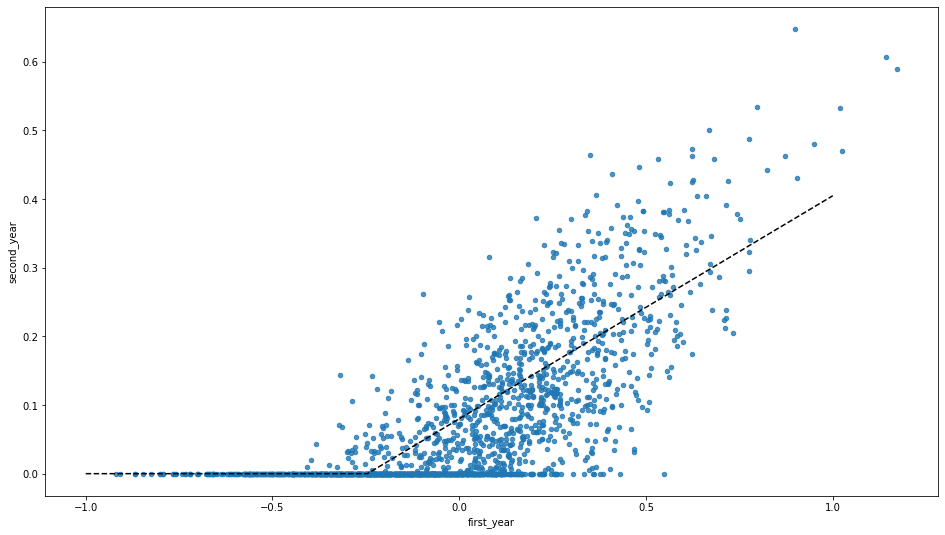

In [18]:
x = np.linspace(-1, 1, 1001)
def model2(xx):
    return max(0, fit.params.Intercept + fit.params.first_year*xx)
y2 = [model2(xx) for xx in x]
ax = df.plot.scatter(x='first_year', y='second_year', figsize=(16, 9), alpha=0.8)
ax.plot(x, y2, '--', color='black')

In [19]:
df['model2_predictions'] = df.first_year.apply(model2)

In [20]:
((df.model2_predictions -  df.second_year) ** 2).mean()

0.00480678243489377

This is slightly better than the original, but only slightly.

### Interlude: The cheat

What if we cheat and we use the hidden variable directly. This is of course impossible in the real world, but it could be instructive. Would it be better at predicting the data? Let's find out.

I'm still going to truncate at 0, but the difference is that I have more data on which to estimate the underlying linear model. Let's try this.

In [21]:
lr = smf.ols(formula = 'second_year_hidden ~ first_year', data=df)
fit = lr.fit()

def model3a(x):
    return fit.params.Intercept + fit.params.first_year*x

def model3b(x):
    return max(0, model3a(x))

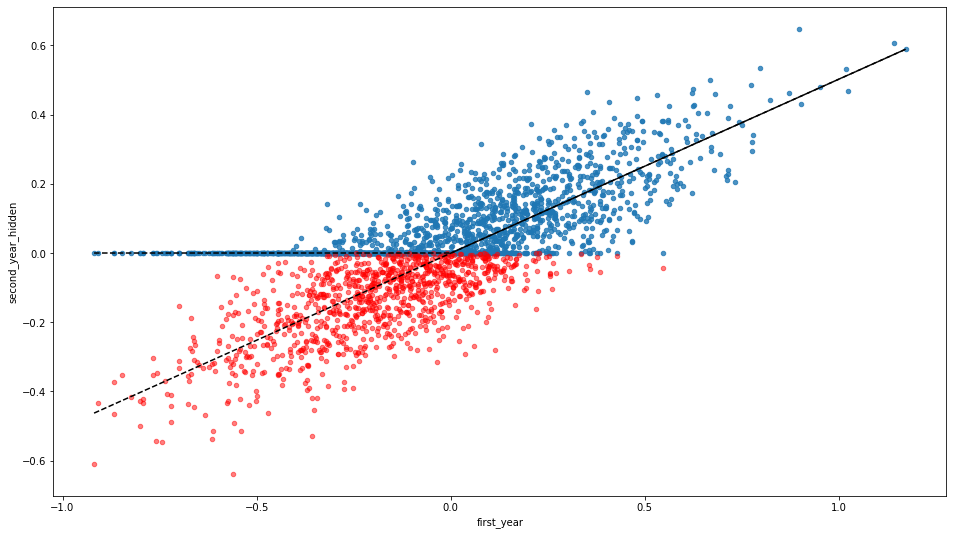

In [22]:
ax = df.plot.scatter('first_year', 'second_year', figsize=(16, 9), alpha=0.8)
df.query('second_year_hidden < 0').plot.scatter('first_year', 'second_year_hidden',
                                                  ax=ax, color='red', alpha=0.5)
x = np.linspace(df.first_year.min(), df.first_year.max(), 1001)
y1 = [model3a(xx) for xx in x]
y2 = [model3b(xx) for xx in x]

plt.plot(x, y1, '--', color='black')
plt.plot(x, y2, '--', color='black')

It looks a bit better to eyeball, but is it actually better?

In [23]:
df['prediction_model3a'] = df.first_year.apply(model3a)
df['prediction_model3b'] = df.first_year.apply(model3b)

In [24]:
((df.prediction_model3a - df.second_year)**2).mean()

0.01666115792299802

In [25]:
((df.prediction_model3b - df.second_year)**2).mean() 

0.0042539531743624745

The first version of this is actually the worst of all the models, but the cut version is the best. Of course, this is accedemic, as in reality we are assuming that you would not have access to this hidden variable.

Let's press on and try the full 'tobit' approach now.

### Tobit Regression

The tobit model assumes that the relationship between y and x is driven by some dummy or hidden variable y* in the normal linear way.

$$y^* = \beta x + u$$

where u is normally distributed noise. We don't actually have access to y^* although in my fake data I do include it, in real life we would not see it. Y is determined as follows"

$$y=\text{max}(0, y^*)$$

often we are not really interested in y^* for its own sake, although in some cases it may have some physical meaning in its own right. These two deceptively simple equations define the tobit regression. We want to find the values of \beta (a single number in our case) as well as answer other related questions which we'll come to later. In general we do this by maximising the log likelihood. We will get to how to do this later, let's build up to the general solution in steps.

There are two important equations that I use in this section. They are stated without proof, but the derivation of them comes from this [youtube video](https://www.youtube.com/watch?v=IwsE8Rr6l6E&ab_channel=AndersMunk-Nielsen). Note in principle they are derivable from what we have said so far, but its a bit complicated.

The tobit regression gives us a formula for the expected value of y given any x, and expresses this in terms of the normal distribution and the CDF of that distribution.

It looks like this:

$$E(y|x) = x\beta\Phi(\frac{x\beta}{\sigma}) + \sigma\phi(\frac{x\beta}{\sigma})$$

Where $\phi$ is the normal distribution and $\Phi$ is its CDF.

In [26]:
from scipy.stats import norm

Now of course the issue is that we don't know either beta or sigma from the data. But because we made up the data ourselves we sort of do know these, so simply as a learning exercise I'm going to plot this funciton and see what it gives me.

In [27]:
def eyx(x, beta, sigma):
    """
    Expected value of y for all y, given x, beta and sigma.
    """
    return x*beta*norm.cdf(x*beta/sigma) + sigma* norm.pdf(x*beta/sigma)

Now in real life we would not be given beta and sigma, but I'm just testing that this formula looks roughly right, so let's plot it against the data and verify that it does indeed fit the data.

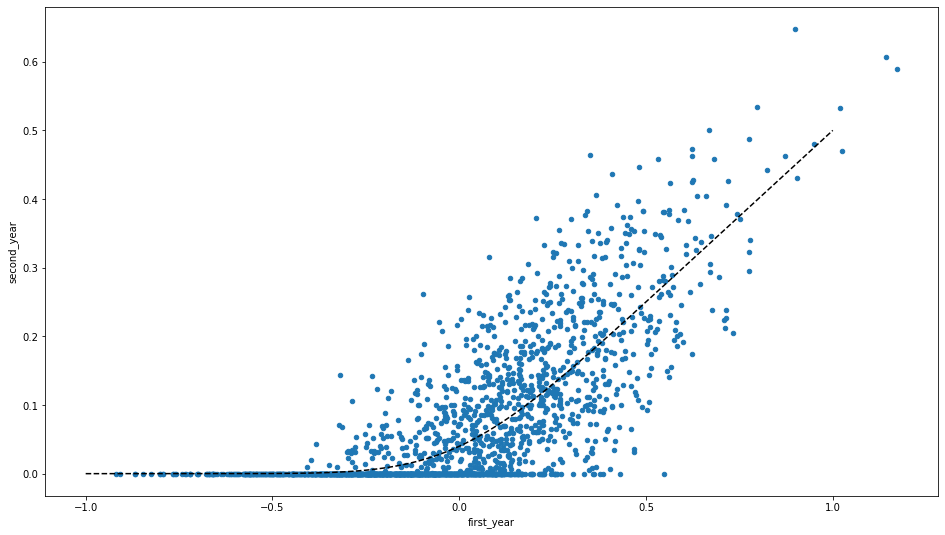

In [28]:
xs = np.linspace(-1, 1, 1001)
ys = [eyx(x, BETA, SIGMA) for x in xs]

ax = df.plot.scatter('first_year', 'second_year', figsize=(16, 9))

ax.plot(xs, ys, '--', color='black')

That does indeed look to be the thing we are looking for. The only issue is that we haven't found a way to actually estimate beta and sigma.

Note that we could in principle simply 'fit' this curve to our data. Find the values of beta and sigma that minimise the mean squared error. This would work to some extent, however, the approach that we actually take is to minimise the negative of the log likelihood. For a normal linear regression these two approaches would be similar, but here they are not identical (although we will show later that the answers that they give are actually fairly similar).

Let's code up the likelihood function as well as see if this works. The derivation of this formular also comes from the video shared above.

It tells us the likelihood of a single datum, given an assumed underlying distribution.

This formula is again simply given, some boffins have worked it out for us. Just remember that it tells us how likely we are to see certain data given an underlying distribution. We then play with the numbers until it gives us the highest likelihood (or in reality do this with a numberical package).

In [29]:
def ll_i(xi, yi, beta, sigma):
    if yi == 0:
        return np.log(1 - norm.cdf(xi*beta/sigma))
    else:
        return np.log(1/sigma*norm.pdf((yi-xi*beta)/sigma))

The above is for one point. Let's work out the sum of all these likelihoods (sum them as they are logs).

In [30]:
def ll(x, y, beta, sigma):
    return sum([ll_i(xi, yi, beta, sigma) for xi, yi in zip(x, y)])

Note that the way that I have coded this is not particularly efficient. We're not worried about that yet, we're just exploring and understanding.

Now let's test that this is roughly sensible. Give it my data, and tell it the correct answer for sigma, and plot for a variety of different betas. We should get the answer we were looking for. That is the actual beta that we pre-supposed lies at the maximum of the data.

In [31]:
betas = np.linspace(-1, 1, 101)
lls = [ll(df.first_year, df.second_year, b, SIGMA) for b in betas]

<ipython-input-29-60e1e2f32f28>:3: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - norm.cdf(xi*beta/sigma))


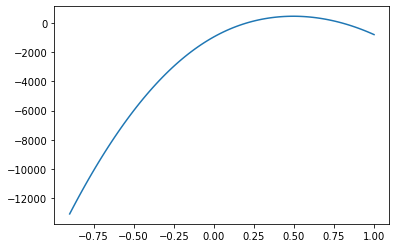

In [32]:
plt.plot(betas, lls)

That looks like it is about right. The peak is around 0.5.

Let's also try the same for sigma.

In [33]:
SIGMA

0.1

In [34]:
sigmas = np.linspace(0, 1, 101)
lls = [ll(df.first_year, df.second_year, BETA, s) for s in sigmas]

<ipython-input-29-60e1e2f32f28>:5: RuntimeWarning: divide by zero encountered in double_scalars
  return np.log(1/sigma*norm.pdf((yi-xi*beta)/sigma))
<ipython-input-29-60e1e2f32f28>:5: RuntimeWarning: invalid value encountered in double_scalars
  return np.log(1/sigma*norm.pdf((yi-xi*beta)/sigma))
<ipython-input-29-60e1e2f32f28>:3: RuntimeWarning: divide by zero encountered in double_scalars
  return np.log(1 - norm.cdf(xi*beta/sigma))
<ipython-input-29-60e1e2f32f28>:3: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - norm.cdf(xi*beta/sigma))


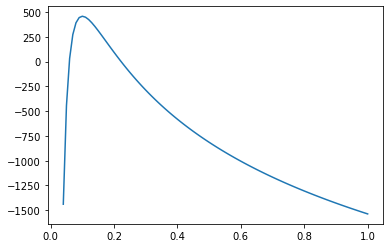

In [35]:
plt.plot(sigmas, lls)

So it seems that in principle this actually works.

We have a formula for the expectation of y given x and two unknown parameters, beta and sigma. We have another formular the log likelihood of these numbers. Up to now we just magiced the values of these parameters from thin air. What we would like to do is to try to estimate for beta and sigma from the data.

Quote from the [textbook](https://economics.ut.ac.ir/documents/3030266/14100645/Jeffrey_M._Wooldridge_Introductory_Econometrics_A_Modern_Approach__2012.pdf):

```
 The log-likelihood for a random sample of size n is obtained by summing ([the log likelihood formula] across all i.
The maximum likelihood estimates of beta and sigma are obtained by maximizing the loglikelihood; this requires numerical methods, although in most cases this is easily done
using a packaged routine.
```

page 634 onwards.

So let's try to use a minimisation package to estimate these parameters.

#### Minimisation

Let's try to minimise the log-likelihood (actually maximise, but I'll add a negative sign to it).

The way I have written it is not too efficient, so I'll tweak it now to be a bit more vectory.

The first step is simply to write a function that returns a number, based on beta and sigma.

In [36]:
x = df.first_year
y = df.second_year

In [37]:
def ll_factory(x, y):
    
    zero_mask = [int(yy==0) for yy in y]
    non_zero_mask = [int(yy > 0) for yy in y]
    
    def ll(V):
        beta, sigma = V
        return - sum(zero_mask * np.log(1 - norm.cdf(x*beta/sigma))
         + non_zero_mask* np.log(1/sigma*norm.pdf((y-x*beta)/sigma)))
    
    return ll

In [38]:
ll = ll_factory(x, y)

And again sanity check this a bit. I can do this because I know the answer, so I plot a range of betas setting sigma at the correct value. Again the minimum should give the true answer. Note that you would not actually do this for real data, I am simply checking that i have not made any mistakes so far.

<ipython-input-37-f5455904aff8>:8: RuntimeWarning: divide by zero encountered in log
  return - sum(zero_mask * np.log(1 - norm.cdf(x*beta/sigma))
<ipython-input-37-f5455904aff8>:8: RuntimeWarning: invalid value encountered in multiply
  return - sum(zero_mask * np.log(1 - norm.cdf(x*beta/sigma))


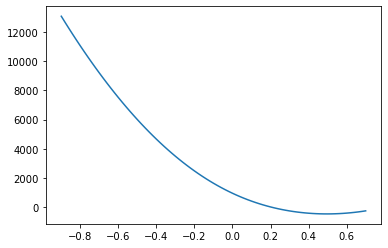

In [39]:
betas = np.linspace(-1, 1, 101)
sigma = 0.1
lls = [ll((b, sigma)) for b in betas]
ax = plt.plot(betas, lls)

Looks about right.

Now we have our function, let's feed it to a minimisation routine.

I'm not going to go too into the nuts and bolts of the minimisation routine, again we're trying to understand the principle, rather than building great code.

In [40]:
from scipy.optimize import minimize

In [41]:
res = minimize(ll, (0, 0.5), method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})

<ipython-input-37-f5455904aff8>:8: RuntimeWarning: divide by zero encountered in log
  return - sum(zero_mask * np.log(1 - norm.cdf(x*beta/sigma))
<ipython-input-37-f5455904aff8>:8: RuntimeWarning: invalid value encountered in multiply
  return - sum(zero_mask * np.log(1 - norm.cdf(x*beta/sigma))


Optimization terminated successfully.
         Current function value: -458.137220
         Iterations: 94
         Function evaluations: 179


In [42]:
beta, sigma = res.x
beta, sigma

(0.4963149893556746, 0.09998165439682383)

That's a bingo!

Those are indeed the values that we wanted. Problem solved. Of course this may not be the best or most efficient way of solving this problem, but it works.

Let's once again plot our real data against this prediction. We can also calculate the least squared error. This is exactly what we did before, except that I'm using the fit values of the parameters, not the real hidden values.

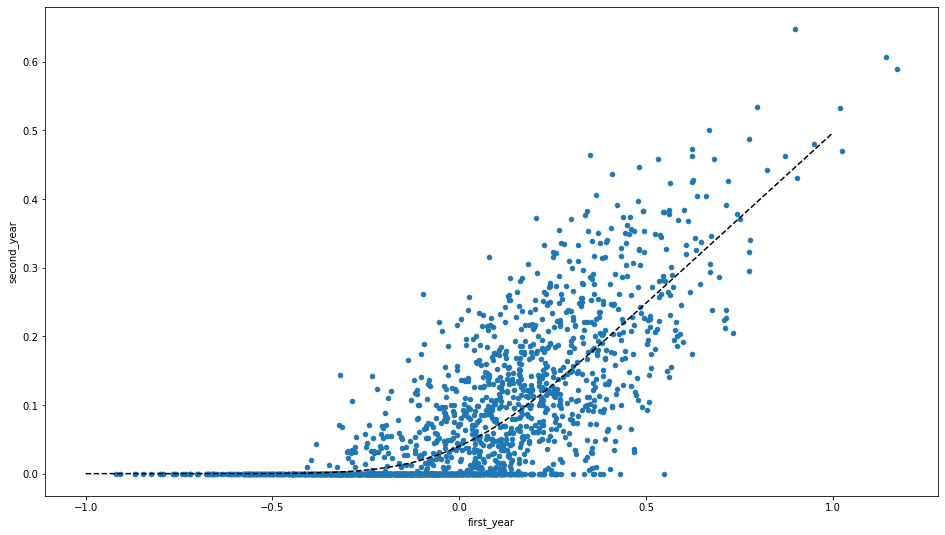

In [43]:
xs = np.linspace(-1, 1, 1001)
ys = [eyx(x, beta, sigma) for x in xs]

ax = df.plot.scatter('first_year', 'second_year', figsize=(16, 9))

ax.plot(xs, ys, '--', color='black')

looks pretty good!

In [44]:
df['tobit_prediction'] = df.first_year.apply(lambda x: eyx(x, beta, sigma))
ols_tobit = ((df.tobit_prediction - df.second_year)**2).mean()
ols_tobit

0.003996936388558873

Which is better than the best case above, even though we were not explicitly minimising this.

#### Asside: OLS

What about the least squares method. What values would this give?

We have a function that fits our data, so we could do a least squares method on this data and try to fit the data. I'm curious if this would give the same (or roughly the same) values.

In [45]:
def mse_fadctory(x, y):

    def mse(V):
        beta, sigma = V
        predictions = eyx(x, beta, sigma)
        errors = predictions - y
        return (errors ** 2).sum()

    return mse


In [46]:
mse = mse_fadctory(df.first_year, df.second_year)

Again a quick sanity check. The real answer for beta should be close to the minimum of this curve.

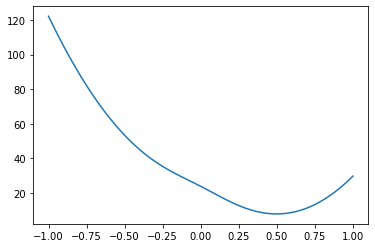

In [47]:
plt.plot(betas, [mse([b, 0.1]) for b in betas])

It is!

And do exactly the same thing here. We're finding a value of beta and sigma that minimised the MSE.

In [48]:
res = minimize(mse, (1., 0.05), method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})
beta_mse, sigma_mse = res.x
beta_mse, sigma_mse

Optimization terminated successfully.
         Current function value: 7.993323
         Iterations: 64
         Function evaluations: 125


(0.49868595068900756, 0.09879851597194361)

Interestingly these figures are almost the same as the ones we had earlier.

In [49]:
beta, sigma

(0.4963149893556746, 0.09998165439682383)

However, the textbook recommends that we use the liklihood maximisation technique because it is numerically safer and possibly more efficient. It is no harder to code really, so no reason not to use it.

That solves the problem.

### Other topics

* Fitting an intercept. The data we have assumes a relationship of the form y* = beta x + noise. Allow for the possibility of an intercept. This could be done by adding a feature that is all ones.
* Computing t (and p) values, we would need this to do the significance tests.
* Binary independent variable. Should be simple in principle.
* Partial effects? (see the economics textbook). You can't simply read of the value of beta and take this as the (partial) effect of the input variable on the depedent variable, as you can in a normal OLS regression.
* The formulars that we have here assume that the data is capped at 0. What if the data is capped at another value? What if it is right cencored. The most obvious way to takle this would simply be to do a transformation of the data to turn it into the original problem. Alternatively you could derive more general versions of the above formulars, although the transformation seems easier, and would amount to the same thing.